In [33]:
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [34]:
# Specify data paths
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [35]:
# Change training classes if necessary
NUM_CLASSES = 9

# Dataset reading

In [36]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [37]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([1595, 1663, 1510,  672,  164,  257,  139,  190,   75]))


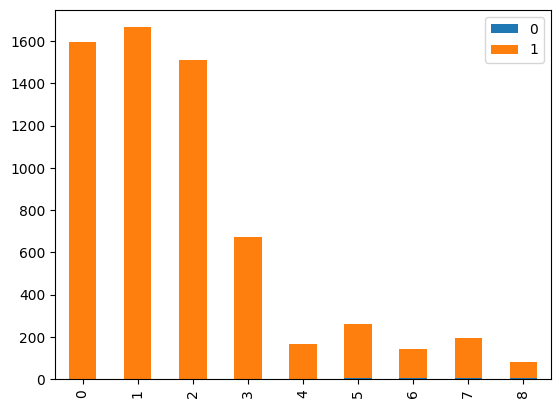

In [39]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

# Model building

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [41]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                1376      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 9)                

In [42]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [43]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [44]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
58/74 [======================>.......] - ETA: 0s - loss: 1.9344 - accuracy: 0.3303
Epoch 1: val_loss improved from inf to 1.43504, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
74/74 [==============================] - 2s 6ms/step - loss: 1.8560 - accuracy: 0.3604 - val_loss: 1.4350 - val_accuracy: 0.5405
Epoch 2/1000
48/74 [==================>...........] - ETA: 0s - loss: 1.2397 - accuracy: 0.5859

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.43504 to 0.91098, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
74/74 [==============================] - 0s 3ms/step - loss: 1.1636 - accuracy: 0.6117 - val_loss: 0.9110 - val_accuracy: 0.7071
Epoch 3/1000
55/74 [=====================>........] - ETA: 0s - loss: 0.8004 - accuracy: 0.7327
Epoch 3: val_loss improved from 0.91098 to 0.61853, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
74/74 [==============================] - 0s 3ms/step - loss: 0.7588 - accuracy: 0.7554 - val_loss: 0.6185 - val_accuracy: 0.8066
Epoch 4/1000
53/74 [====================>.........] - ETA: 0s - loss: 0.5240 - accuracy: 0.8629
Epoch 4: val_loss improved from 0.61853 to 0.43062, saving model to model/keypoint_classifier/keypoint_classifier.hdf5
74/74 [==============================] - 0s 3ms/step - loss: 0.5035 - accuracy: 0.8708 - val_loss: 0.4306 - val_accuracy: 0.9075
Epoch 5/1000
62/74 [========================>.....] - ETA: 0s -

In [45]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [46]:
# Model evaluation
# TODO Test on loaded model
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

25/25 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9955


In [47]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 84ms/step
[2.4816995e-07 2.0154066e-04 2.8883248e-15 3.2730616e-16 2.9036948e-13
 2.1070568e-07 8.5227388e-24 9.9979800e-01 1.8310771e-15]
7


# Confusion matrix

49/49 [==============================] - 0s 1ms/step


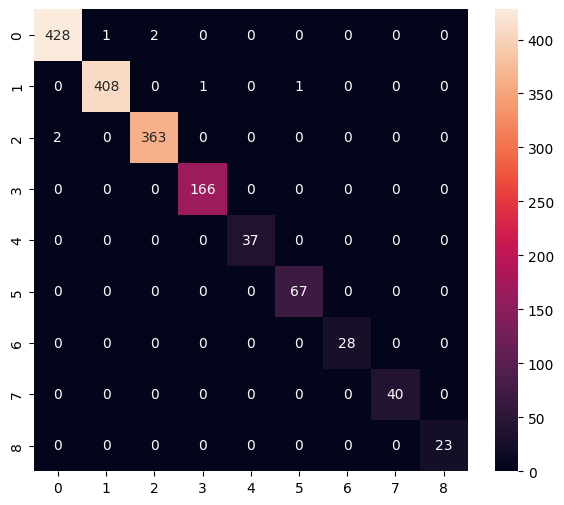

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       431
           1       1.00      1.00      1.00       410
           2       0.99      0.99      0.99       365
           3       0.99      1.00      1.00       166
           4       1.00      1.00      1.00        37
           5       0.99      1.00      0.99        67
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00        23

    accuracy                           1.00      1567
   macro avg       1.00      1.00      1.00      1567
weighted avg       1.00      1.00      1.00      1567



In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [49]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/kf/9vc6x6n97q942grwf1zf0trw0000gn/T/tmp03uw5dkx/assets


INFO:tensorflow:Assets written to: /var/folders/kf/9vc6x6n97q942grwf1zf0trw0000gn/T/tmp03uw5dkx/assets
2023-10-19 12:45:48.320017: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-19 12:45:48.320044: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-19 12:45:48.322744: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/kf/9vc6x6n97q942grwf1zf0trw0000gn/T/tmp03uw5dkx
2023-10-19 12:45:48.325877: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-19 12:45:48.325902: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/kf/9vc6x6n97q942grwf1zf0trw0000gn/T/tmp03uw5dkx
2023-10-19 12:45:48.331395: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-10-19 12:45:48.333589: I tensorflow/cc/saved_model/load

8032

## Inference test

In [51]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [52]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [53]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [54]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 607 µs, sys: 343 µs, total: 950 µs
Wall time: 718 µs


In [55]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.5059413e-07 1.9959598e-04 2.4500233e-15 3.1080654e-16 2.5947408e-13
 2.1029174e-07 7.6230382e-24 9.9980003e-01 1.6501217e-15]
7


## Download model

In [ ]:
!zip -r model.zip keypoint_classifier  



---


# ❗️Hyperparameters Tuning

In [ ]:
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [ ]:
# Init parameters to tune
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([8, 16, 32]))
HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([8, 16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

In [ ]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_NUM_UNITS_2,HP_NUM_UNITS_3, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)

In [ ]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_3], activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
  
  model.compile(
    optimizer=hparams[HP_OPTIMIZER],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
  
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)

  model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
               cp_callback,
               es_callback,
               ]
  ) 

  # Load model with best accuracy
  model = tf.keras.models.load_model(model_save_path)

  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for num_units_3 in HP_NUM_UNITS_3.domain.values:
      for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.1):
        for optimizer in HP_OPTIMIZER.domain.values:
          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_NUM_UNITS_3: num_units_3,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

In [ ]:
# !ATTENTION! Works only in Colab
%tensorboard --logdir logs/hparam_tuning

In [ ]:
!rm -rf logs